In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
from IPython.display import Audio, display
from keras.utils import np_utils

import librosa # read and write WAV files
import matplotlib.pyplot as plt # generate the visualizations

# MLP Classifier 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# LSTM Classifier
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential 
from keras.layers import *
from keras.optimizer_v1 import rmsprop

print("loaded libraries")


loaded libraries


In [2]:
import librosa 
import soundfile
import os,glob,pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import accuracy_score

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
Test="/content/gdrive/My Drive/Project/Dataset/Test/"

In [5]:
def extract_mfcc(wav_file_name):
  y, sr =librosa.load(wav_file_name)
  mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
  return mfccs

In [6]:
#### load radvess speech data #####
ravdess_speech_labels = [] # to save extracted label/file
ravdess_speech_data = [] # to save extracted features/file
for dirname, _,filenames in os.walk('/content/gdrive/My Drive/Project/Dataset/Test/'):
  for filename in filenames:
      ravdess_speech_labels.append(int(filename[7:8]) - 1) # the index 7 and 8 of the file name represent the emotion label
      wav_file_name = os.path.join(dirname, filename)
      ravdess_speech_data.append(extract_mfcc(wav_file_name)) # extract MFC features/file
        
print("Finish loading the Dataset")


Finish loading the Dataset


In [7]:
#### convert data and label to array
ravdess_speech_data_array = np.asarray(ravdess_speech_data) # convert the input to an array
ravdess_speech_label_array = np.array(ravdess_speech_labels)
ravdess_speech_label_array.shape #get tuple of array dimensions

#### make categorical labels
labels_categorical = to_categorical(ravdess_speech_label_array) # converts a  class vector (integers) to binary class matrix
labels_categorical.shape

(1437, 8)

In [8]:
ravdess_speech_data_array.shape

(1437, 40)

In [9]:
ravdess_directory_list = os.listdir(Test)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Test, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(Test, dir, wav)))

In [10]:
Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

In [11]:
Ravdess_df.Emotion.replace({1:'negative', 2:'positive', 3:'neutral', 4:'sad', 5:'calm', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotion,Path
0,negative,/content/gdrive/My Drive/Project/Dataset/Test/...
1,negative,/content/gdrive/My Drive/Project/Dataset/Test/...
2,negative,/content/gdrive/My Drive/Project/Dataset/Test/...
3,disgust,/content/gdrive/My Drive/Project/Dataset/Test/...
4,surprise,/content/gdrive/My Drive/Project/Dataset/Test/...


# **Feature extraction of our Test dataset**

In [12]:
def mfcc(data, sampling_rate):
    mfcc_feature = librosa.feature.mfcc(y = data, sr = sampling_rate)
    return np.ravel(mfcc_feature.T)

In [13]:
path = np.array(Ravdess_df["Path"])[100]
data, sampling_rate = librosa.load(path, duration = 2.5, offset = 0.6)
print("Length of data: ", len(data))
print("MFrequency Cepstral Coefficients: ", mfcc(data, sampling_rate).shape)

Length of data:  55125
MFrequency Cepstral Coefficients:  (2160,)


In [14]:
def get_features(path, duration =2.5, offset = 0.6):
    data, sampling_rate = librosa.load(path, duration = duration,  offset = offset)
    return mfcc(data, sampling_rate)

In [15]:
# Convert an array into multidimension
data, sampling_rate = librosa.load(path)
type(np.ravel(librosa.feature.mfcc(y = data, sr = sampling_rate).T))

numpy.ndarray

# **We have used Test dataset for features processing**

In [16]:
X, Y = [], []
print('Feature processing...')
for path, emotion, index in zip(Ravdess_df.Path, Ravdess_df.Emotion, range(Ravdess_df.Path.shape[0])):
    data, sampling_rate = librosa.load(path, duration = 2.5,  offset = 0.6)
    mfcc_feature = np.mean(librosa.feature.mfcc(y = data, sr = sampling_rate,n_mfcc = 40).T,axis=0)
    if index % 50 == 0:
        print(f"{index} samples has been processed...")
    X.append(mfcc_feature)
    Y.append(emotion)
print('Done.')

Feature processing...
0 samples has been processed...
50 samples has been processed...
100 samples has been processed...
150 samples has been processed...
200 samples has been processed...
250 samples has been processed...
300 samples has been processed...
350 samples has been processed...
400 samples has been processed...
450 samples has been processed...
500 samples has been processed...
550 samples has been processed...
600 samples has been processed...
650 samples has been processed...
700 samples has been processed...
750 samples has been processed...
800 samples has been processed...
850 samples has been processed...
900 samples has been processed...
950 samples has been processed...
1000 samples has been processed...
1050 samples has been processed...
1100 samples has been processed...
1150 samples has been processed...
1200 samples has been processed...
1250 samples has been processed...
1300 samples has been processed...
1350 samples has been processed...
1400 samples has been

In [17]:
features_path = './feature_mfcc.csv'

In [18]:
extracted_df = pd.DataFrame(X)
extracted_df['labels'] = Y
extracted_df.to_csv(features_path, index = False)
extracted_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,labels
0,-513.161682,100.692581,1.673225,19.829174,9.649284,-9.172473,1.480463,-6.195527,-17.171068,-0.135856,...,-1.943797,-4.846641,-1.068353,-3.315908,-0.491997,-5.054212,-2.609374,-3.267921,-3.015429,negative
1,-530.776855,100.967529,2.411982,20.636997,9.064438,-2.416541,0.486590,-8.169662,-17.353279,0.190391,...,-2.101964,-3.788109,-0.410305,-1.640984,-0.330937,-5.097245,-2.733362,-4.696524,-2.235636,negative
2,-516.290710,106.861115,8.163457,24.569471,8.465314,-6.570309,2.088562,-8.266725,-16.342669,0.433360,...,-0.927255,-4.525151,-0.817962,-3.027529,-0.595611,-4.291883,-3.338907,-4.140358,-2.031812,negative
3,-453.284790,77.105598,-11.498585,30.386398,10.005284,-13.810644,-4.903659,-2.094193,-18.421190,4.811186,...,-0.526295,-5.173812,-0.798587,-4.774112,0.901893,-5.189515,-1.325623,-5.390472,-1.596383,disgust
4,-463.800354,66.869438,-10.476361,14.614882,4.407048,-7.829010,-9.139933,-9.001820,-24.349178,5.009973,...,3.080481,-2.276829,1.633616,-2.571058,2.677974,-1.840437,-1.777182,-3.757119,-0.070453,surprise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-579.777771,67.062408,-24.091080,0.316857,2.688474,-8.767527,-17.641972,-12.834249,-17.555632,1.555590,...,5.733325,-1.499603,2.840441,0.329792,7.891118,4.922855,5.698904,0.986953,6.011318,neutral
96,-418.106781,32.058674,-30.043259,-0.343684,-11.742113,-13.943666,-23.533859,-16.713631,-20.419405,-2.519686,...,-0.837669,-5.674428,0.210056,-1.872227,0.949029,-0.357682,-2.179889,-3.651505,-0.469725,fear
97,-458.542908,62.842453,-14.992556,2.498734,-10.568342,-12.004517,-17.396044,-12.233983,-27.022377,-3.459474,...,4.735918,-4.498236,-1.369293,-1.789471,7.460616,5.977652,10.327331,3.204480,4.135767,calm
98,-494.479370,55.991924,-20.231319,6.324542,-2.518042,-10.514001,-20.566410,-11.657248,-21.975496,-1.772498,...,11.290668,11.002004,14.634570,10.802449,7.184299,1.493218,0.947619,-2.399111,2.213209,fear


In [19]:
extracted_df.shape

(1437, 41)

In [20]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(extracted_df.labels)
extracted_df['categorical_label'] = le.transform(extracted_df.labels)

In [21]:
Y = extracted_df.categorical_label
from tensorflow.keras.utils import to_categorical
Y = to_categorical(Y)

# **Splitting**

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = np.array(X)
Y = np.array(Y)
X = np.squeeze(X)
X = np.expand_dims(X,-1)
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.05, random_state=42)

In [24]:
X.shape

(1437, 40, 1)

In [25]:
Y.shape

(1437, 8)

# **We have imported some packages for LSTM model implementation**

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.models import Sequential 
#from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
#from sklearn.metrics import precision_score
#from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
#from sklearn.metrics import cohen_kappa_score
#from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as pyplot

# **LSTM Model**

In [27]:
LSTM_model = Sequential([
    LSTM(128, return_sequences=False, input_shape = (40,1)),
    #Dense(128,activation = 'relu'),
    #Dropout(0.2),
    Dense(64,activation = 'relu'),
    Dropout(0.2),
    Dense(32,activation = 'relu'),
    Dropout(0.2),
    Dense(8,activation='softmax')
])

In [28]:
LSTM_model.compile(loss = 'categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
Total params: 77,160
Trainable params: 77,160
Non-traina

In [29]:
LSTM_history = LSTM_model.fit(X
                              ,Y, 
                              validation_data =(x_val,y_val),
                              epochs =100,
                               batch_size =64, 
                              shuffle = True)

Epoch 1/100
23/23 [==============================] - 6s 101ms/step - loss: 2.0045 - accuracy: 0.2102 - val_loss: 1.9719 - val_accuracy: 0.1765
Epoch 2/100
23/23 [==============================] - 2s 71ms/step - loss: 1.8249 - accuracy: 0.2791 - val_loss: 1.9431 - val_accuracy: 0.1765
Epoch 3/100
23/23 [==============================] - 2s 72ms/step - loss: 1.7810 - accuracy: 0.3013 - val_loss: 1.8705 - val_accuracy: 0.1961
Epoch 4/100
23/23 [==============================] - 2s 71ms/step - loss: 1.7334 - accuracy: 0.3215 - val_loss: 1.8495 - val_accuracy: 0.1765
Epoch 5/100
23/23 [==============================] - 2s 72ms/step - loss: 1.6948 - accuracy: 0.3500 - val_loss: 1.8651 - val_accuracy: 0.1765
Epoch 6/100
23/23 [==============================] - 2s 71ms/step - loss: 1.6713 - accuracy: 0.3633 - val_loss: 1.8410 - val_accuracy: 0.2157
Epoch 7/100
23/23 [==============================] - 2s 71ms/step - loss: 1.6627 - accuracy: 0.3688 - val_loss: 1.8002 - val_accuracy: 0.1961
Epoch

# **Plot the result**

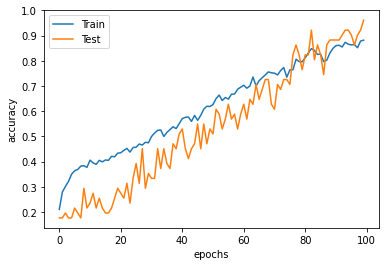

In [30]:
plt.plot(LSTM_history.history['accuracy'])
plt.plot(LSTM_history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

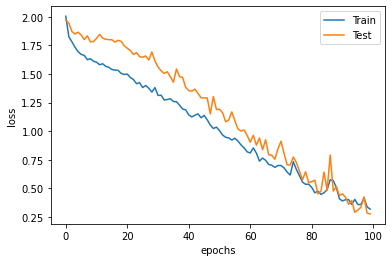

In [31]:
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()

In [32]:
# predict probabilities for test set
y_probs = LSTM_model.predict(x_test, verbose=0)
# predict crisp classes for test set
y_classes = np.argmax(y_probs,1)
y_true_classes = np.argmax(y_test,1)

In [33]:
y_classes.shape

(432,)

In [34]:
y_true_classes.shape

(432,)

In [35]:
f1 = f1_score(y_true_classes,y_classes,pos_label='positive'
                                           ,average='micro')
print('F1 score: %f' % f1)

F1 score: 0.949074


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


In [36]:
test_emotions = {
     1:'negative',
     2:'positive',
     3:'neutral',
     4:'sad',
     5:'calm',
     6:'fear',
     7:'disgust',
     8:'surprise'
    }

In [49]:
predict('/content/gdrive/My Drive/Project/Dataset/Test/Actor_06/03-01-02-01-01-02-06.wav')

negative


In [50]:
predict('/content/gdrive/My Drive/Project/Dataset/Test/Actor_07/03-01-02-01-01-02-07.wav')

negative


In [51]:
predict('/content/gdrive/My Drive/Project/Dataset/Test/Actor_04/03-01-01-02-01-00-62.wav')

neutral


In [52]:
predict('/content/gdrive/My Drive/Project/Dataset/Test/Actor_08/03-01-01-01-01-02-18.wav')

neutral


In [53]:
predict('/content/gdrive/My Drive/Project/Dataset/Test/Actor_08/03-01-02-01-01-01-16.wav')

neutral


In [54]:
predict('/content/gdrive/My Drive/Project/Dataset/Test/Actor_08/03-01-01-01-01-02-16.wav')

neutral


In [55]:
predict('/content/gdrive/My Drive/Project/Dataset/Test/Actor_08/03-01-01-01-01-01-15.wav')

neutral


In [56]:
predict('/content/gdrive/My Drive/Project/Dataset/Test/Actor_08/03-01-01-01-01-01-20.wav')

neutral
